In [1]:
from fastprogress import progress_bar
import torch
import matplotlib as mpl
import fastcore.all as fc
from datasets import load_dataset
from miniai.datasets import inplace, DataLoaders

/scratch/users/carles/mambaforge/envs/mini-diffusers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from miniai.utils import set_seed

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 256
dsd = load_dataset(name)

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 128
dsd = load_dataset(name)

In [6]:
from miniai.diffusion import dl_ddpm
import torch.nn.functional as F
import torchvision.transforms.functional as TF

@inplace
def transformi(b): 
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

In [7]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [8]:
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [9]:
from torch.utils.data import DataLoader, default_collate
import math

In [10]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt,t),eps = b = next(iter(dl))

# Train

In [11]:
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from miniai.learner import DeviceCB, ProgressCB, MetricsCB
from miniai.sgd import BatchSchedCB
from miniai.accel import MixedPrecision
from miniai.unet import EmbUNetModel
from miniai.learner import Learner
import torch.nn as nn

In [12]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)

sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]

model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.095,0,train
0.063,0,eval
0.051,1,train
0.046,1,eval
0.045,2,train
0.043,2,eval
0.042,3,train
0.042,3,eval
0.041,4,train
0.041,4,eval


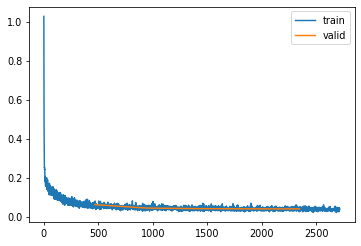

KeyboardInterrupt: 

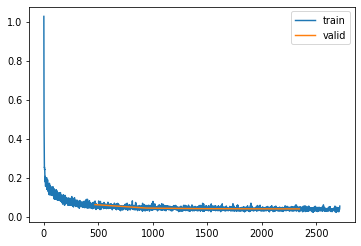

In [13]:
learn.fit(epochs)

In [ ]:
sum(p.numel() for p in model.parameters())